In [1]:
%matplotlib inline
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
import sklearn
import seaborn as sns
import geopandas as gpd
import scipy
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import skew
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn import datasets, cluster, metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, Imputer
from collections import defaultdict

In [2]:
print("Python:", sys.version[:5])
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Seaborn:", scipy.__version__)
print("GeoPandas:", gpd.__version__)
print("SciPy:", scipy.__version__)

Python: 3.7.0
Pandas: 0.23.4
Numpy: 1.15.3
Matplotlib: 3.0.1
Scikit-learn: 0.20.0
Seaborn: 1.1.0
GeoPandas: 0.3.0
SciPy: 1.1.0


In [3]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
prices_folder = Path("data/")
cols_2excl = ['CLASS', 'STNO', 'STnu', 'FLATPOSN', 'YEAR OF SALE (BUSINESS)', 'RPI', 'DEFLATOR', 'OMIT OR USE']
new_cols = ['street', 'postcode', 'sale_month', 'sale_year', 'sale_date', 'sale_quarter', 'nominal_price',
            'july_2013_price', 'buyer_origin', 'build', 'local_housing_forum']

fp = "data/glasgow_shp_2011/DZ_2011_EoR_Glasgow_City.shp"
map_df = gpd.read_file(fp)

In [4]:
map_df.head()

,GSS_CODEDZ,DZ_Name,GSS_CODECA,CA_Name,GSS_CODEIZ,geometry
0,S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,..."
1,S01003026,None,S12000046,Glasgow_City,S02000584,"POLYGON ((258523 659616, 258532 659448, 258583..."
2,S01003027,None,S12000046,Glasgow_City,S02000587,"POLYGON ((254367.8425000003 658647.1636999995,..."
3,S01003028,None,S12000046,Glasgow_City,S02000585,"POLYGON ((260169 658643, 260179 658592, 260209..."
4,S01003029,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259204 658200, 259174 658180, 259164..."


In [5]:
# map_df.plot()

In [6]:
def concatenate(folder):
    file_list = folder.glob("*.csv")  # Find .csv files
    df_list = []
    for file_name in file_list:
        single_df = pd.read_csv(file_name, low_memory=False)
        clean_df = single_df[:-1]  # Remove last row of each CSV file as it's not relevant
        df_list.append(clean_df)
    df = pd.concat(df_list, axis=0, sort=False)  # Concatenate CSV files
    df.drop(columns=cols_2excl, inplace=True)  # Drop useless columns
    df.columns = new_cols  # Rename columns with code-friendly terms
    # Regular Expression to convert date formats from YYYY-MM-DD to YYYY-MM as DD was always 01 anyway
    df.sale_date = df.sale_date.str.replace(r'-\d{2}$', r'', regex=True)
    # Regular Expression to convert date formats from DD/MM/YYYY to YYYY-MM
    df.sale_date = df.sale_date.str.replace(r'\d{2}\/(\d{2})\/(\d{4})$', r'\2-\1', regex=True)
    return df

In [7]:
def from_xls():
    xls = pd.ExcelFile('data/datazones.xls')
    dz_df = pd.read_excel(xls, 'Sheet1')
    dz_df = dz_df[['Postcode', 'DataZone']]
    dz_df.columns = ['postcode', 'datazone']
    return dz_df

In [8]:
def merge_df(simd_df, left_df, column, year, first):
    new_col = ''.join(column + '_' + str(year))
    right_df = simd_df[['Datazone', new_col]]
    right_df.columns = ['datazone', column]
    right_df['sale_year'] = year
    merged_df = pd.merge(left_df, right_df, how='left', on=['datazone', 'sale_year'])
    dupl_col_x = ''.join(column + '_x')
    dupl_col_y = ''.join(column + '_y')
    if not first:
        merged_df[column] = merged_df[dupl_col_x].fillna(merged_df[dupl_col_y])
        merged_df.drop(columns=[dupl_col_x, dupl_col_y], inplace=True)
    return merged_df

In [9]:
def create_pdf_fig(filename):
    pwd = os.path.abspath(os.path.dirname(sys.argv[0]))
    graph_path = os.path.join(pwd, '{}.pdf'.format(filename))
    pdf = PdfPages(graph_path)
    plt.savefig(pdf, format='pdf', bbox_inches='tight')
    plt.show()
    pdf.close()
    pdf = None

In [10]:
dataframe = concatenate(prices_folder)
datazone_df = from_xls()

merged = pd.merge(dataframe, datazone_df, on='postcode')

In [11]:
overall_simd_df = pd.read_csv('data/simd/simd-overall-2004-2012-glasgow-v2.csv')
employ_simd_df = pd.read_csv('data/simd/simd-employment-2004-2012-glasgow-v2.csv')
income_simd_df = pd.read_csv('data/simd/simd-income-2004-2012-glasgow-v2.csv')
health_simd_df = pd.read_csv('data/simd/simd-health-2004-2012-glasgow-v2.csv')
edu_simd_df = pd.read_csv('data/simd/simd-education-2004-2012-glasgow-v2.csv')
geo_simd_df = pd.read_csv('data/simd/simd-geographic-access-2004-2012-glasgow-v2.csv')
housing_simd_df = pd.read_csv('data/simd/simd-housing-2004-2012-glasgow-v2.csv')
crime_simd_df = pd.read_csv('data/simd/simd-crime-2006-2012-glasgow-v2.csv')

overall_col = 'overall_deprivation_rank'
overall_04 = merge_df(overall_simd_df, merged, overall_col, 2004, True)
overall_06 = merge_df(overall_simd_df, overall_04, overall_col, 2006, False)
overall_09 = merge_df(overall_simd_df, overall_06, overall_col, 2009, False)
overall_12 = merge_df(overall_simd_df, overall_09, overall_col, 2012, False)

empl_col = 'employment_deprivation_rank'
empl_04 = merge_df(employ_simd_df, overall_12, empl_col, 2004, True)
empl_06 = merge_df(employ_simd_df, empl_04, empl_col, 2006, False)
empl_09 = merge_df(employ_simd_df, empl_06, empl_col, 2009, False)
empl_12 = merge_df(employ_simd_df, empl_09, empl_col, 2012, False)

income_col = 'income_deprivation_rank'
income_04 = merge_df(income_simd_df, empl_12, income_col, 2004, True)
income_06 = merge_df(income_simd_df, income_04, income_col, 2006, False)
income_09 = merge_df(income_simd_df, income_06, income_col, 2009, False)
income_12 = merge_df(income_simd_df, income_09, income_col, 2012, False)

health_col = 'health_deprivation_rank'
health_04 = merge_df(health_simd_df, income_12, health_col, 2004, True)
health_06 = merge_df(health_simd_df, health_04, health_col, 2006, False)
health_09 = merge_df(health_simd_df, health_06, health_col, 2009, False)
health_12 = merge_df(health_simd_df, health_09, health_col, 2012, False)

edu_col = 'education_deprivation_rank'
edu_04 = merge_df(edu_simd_df, health_12, edu_col, 2004, True)
edu_06 = merge_df(edu_simd_df, edu_04, edu_col, 2006, False)
edu_09 = merge_df(edu_simd_df, edu_06, edu_col, 2009, False)
edu_12 = merge_df(edu_simd_df, edu_09, edu_col, 2012, False)

geo_col = 'geographic_access_deprivation_rank'
geo_04 = merge_df(geo_simd_df, edu_12, geo_col, 2004, True)
geo_06 = merge_df(geo_simd_df, geo_04, geo_col, 2006, False)
geo_09 = merge_df(geo_simd_df, geo_06, geo_col, 2009, False)
geo_12 = merge_df(geo_simd_df, geo_09, geo_col, 2012, False)

housing_col = 'housing_deprivation_rank'
housing_04 = merge_df(housing_simd_df, geo_12, housing_col, 2004, True)
housing_06 = merge_df(housing_simd_df, housing_04, housing_col, 2006, False)
housing_09 = merge_df(housing_simd_df, housing_06, housing_col, 2009, False)
housing_12 = merge_df(housing_simd_df, housing_09, housing_col, 2012, False)

crime_col = 'crime_deprivation_rank'
crime_06 = merge_df(crime_simd_df, housing_12, crime_col, 2006, True)
crime_09 = merge_df(crime_simd_df, crime_06, crime_col, 2009, False)
crime_12 = merge_df(crime_simd_df, crime_09, crime_col, 2012, False)

df = crime_12

In [12]:
df = df.sort_values(by=['sale_date', 'july_2013_price'], ascending=False)
df = df[['street', 'postcode', 'datazone', 'local_housing_forum', overall_col, empl_col, income_col,
                     health_col, edu_col, geo_col, housing_col, crime_col, 'sale_date', 'sale_quarter',
                     'sale_year', 'sale_month', 'nominal_price', 'july_2013_price', 'build', 'buyer_origin']]

In [13]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
years = ['2004','2005','2006','2007','2008','2009','2010','2011','2012']

def inc(string):
    l = []
    year = 2004
    for i in range(0,9):
        if string == 't':
            n = len(df[df.sale_year.isin([str(year)])])
        else:
            n = len(df[df.sale_year.isin([str(year)]) & df.build.isin([string])])
        l.append(n)
        year+=1
    return l
                   
n = inc('NEW')
r = inc('RESALE')
t = inc('t')

_X = np.arange(len(years))

plt.bar(_X - 0.2, n, 0.2, color='c')
plt.bar(_X, r, 0.2, color='y')
plt.bar(_X+0.2, t, 0.2, color='m')
plt.xticks(_X, years) # set labels manually
plt.grid(linestyle=':', linewidth=0.5, axis='y')
plt.title("House Sales 2004 - 2012 by house type")
plt.xlabel("Year")
plt.ylabel("House Sales")
ax.legend(('New builds', 'Resale','Total'))
fig.savefig('sales_per_year.pdf', bbox_inches="tight")

In [14]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
years = ['2004','2005','2006','2007','2008','2009','2010','2011','2012']

def inc(quarter):
    l = []
    year = 2004
    for i in range(0,9):
        string = str(year) + ' Q' + str(quarter)
        amount = len(df[df['sale_quarter'] == string])
        l.append(amount)
        year+=1
    return l
        
q1 = inc(1)
q2 = inc(2)
q3 = inc(3)
q4 = inc(4)

_X = np.arange(len(years))

plt.bar(_X - 0.1, q1, 0.1, color='r')
plt.bar(_X, q2, 0.1, color='g')
plt.bar(_X + 0.1, q3, 0.1, color='b')
plt.bar(_X + 0.2, q4, 0.1, color='c')
plt.xticks(_X, years) # set labels manually
plt.grid(linestyle=':', linewidth=0.5, axis='y')
plt.title("House Sales 2004 - 2012 by quarter")
plt.xlabel("Years")
plt.ylabel("House Sales")
ax.legend(('Q1', 'Q2',
           'Q3', 'Q4'))
fig.savefig('sales_per_quarter.pdf', bbox_inches="tight")

In [15]:
# Remove some columns
df.drop(columns=['nominal_price', 'street', 'postcode', 'sale_date',
                 'sale_quarter', 'local_housing_forum'], inplace=True)

In [16]:
df = df.rename(index=str, columns={"sale_month": "month", "sale_year": "year", "sale_quarter":"quarter", "sale_date":"date",
                                      "crime_deprivation_rank":"crime", "housing_deprivation_rank":"housing",
                                      "geographic_access_deprivation_rank":"geographic_access", "education_deprivation_rank":"education",
                                      "health_deprivation_rank":"health", "income_deprivation_rank":"income",
                                      "employment_deprivation_rank":"employment", "overall_deprivation_rank":"overall",
                                      "july_2013_price":"price"})

In [17]:
total_dz = 6505
df.overall = df.overall/total_dz
df.employment = df.employment/total_dz
df.income = df.income/total_dz
df.health = df.health/total_dz
df.education = df.education/total_dz
df.geographic_access = df.geographic_access/total_dz
df.housing = df.housing/total_dz
df.crime = df.crime/total_dz

In [18]:
# Drop NaN rows, keeps 2006, 2009, 2012 only
df = df[pd.notnull(df['overall'])]

# df = df.fillna(df.median())

In [19]:
median_2004 = df[df.year.isin(['2004'])]['overall'].mean()
median_2006 = df[df.year.isin(['2006'])]['overall'].mean()
median_2009 = df[df.year.isin(['2009'])]['overall'].mean()
median_2012 = df[df.year.isin(['2012'])]['overall'].mean()

x=['2004', '2006','2009','2012']
y=[median_2004, median_2006,median_2009,median_2012]

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.bar(x, y, width=0.3, color='g')
plt.title("Mean Overall SIMD per Year")
plt.xlabel('Year')
plt.ylabel('Overall SIMD Score (0 - 1)')
fig.savefig('mean_ov_simd_per_year.pdf', bbox_inches="tight")

In [20]:
df_for_map = df[['datazone','price','overall','employment','income','health','education','geographic_access','housing','crime','year','month','build']]
df_for_map.head()

,datazone,price,overall,employment,income,health,education,geographic_access,housing,crime,year,month,build
82784,S01003453,925751.62,0.756956,0.753882,0.706687,0.904381,0.446580,0.920984,0.079785,0.406149,2012,12.0,RESALE
61074,S01003597,740601.30,0.897925,0.831514,0.920830,0.654727,0.890392,0.567871,0.736972,0.543428,2012,12.0,RESALE
76796,S01003545,682931.52,0.977095,0.874251,0.914527,0.994158,0.922367,0.910223,0.221676,0.658109,2012,12.0,RESALE
46540,S01003257,627285.25,0.520676,0.670869,0.396925,0.645657,0.448117,0.301614,0.156649,0.613374,2012,12.0,RESALE
23603,S01003025,624502.94,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012,12.0,RESALE


In [21]:
merged_map = map_df.set_index('GSS_CODEDZ').join(df_for_map.set_index('datazone'))
merged_map.head()

,DZ_Name,GSS_CODECA,CA_Name,GSS_CODEIZ,geometry,price,overall,employment,income,health,education,geographic_access,housing,crime,year,month,build
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",624502.94,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012.0,12.0,RESALE
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",152504.07,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012.0,11.0,RESALE
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",254173.45,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012.0,10.0,RESALE
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",454375.52,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012.0,6.0,RESALE
S01003025,None,S12000046,Glasgow_City,S02000584,"POLYGON ((259868.7037000004 656693.6532000005,...",489103.09,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012.0,4.0,RESALE


In [22]:
df.to_csv(path_or_buf='dataframe.csv', index=False)

In [23]:
df.year = df.year.astype(str)
df.month = pd.to_numeric(df.month, downcast='integer')
df.month = df.month.astype(str)

In [24]:
print(df.dtypes)

datazone              object
overall              float64
employment           float64
income               float64
health               float64
education            float64
geographic_access    float64
housing              float64
crime                float64
year                  object
month                 object
price                float64
build                 object
buyer_origin          object
dtype: object


In [25]:
df.head()

,datazone,overall,employment,income,health,education,geographic_access,housing,crime,year,month,price,build,buyer_origin
82784,S01003453,0.756956,0.753882,0.706687,0.904381,0.446580,0.920984,0.079785,0.406149,2012,12,925751.62,RESALE,GLASGOW
61074,S01003597,0.897925,0.831514,0.920830,0.654727,0.890392,0.567871,0.736972,0.543428,2012,12,740601.30,RESALE,GLASGOW
76796,S01003545,0.977095,0.874251,0.914527,0.994158,0.922367,0.910223,0.221676,0.658109,2012,12,682931.52,RESALE,GLASGOW
46540,S01003257,0.520676,0.670869,0.396925,0.645657,0.448117,0.301614,0.156649,0.613374,2012,12,627285.25,RESALE,GLASGOW
23603,S01003025,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012,12,624502.94,RESALE,CLARKSTON


In [26]:
# df.local_housing_forum = df.local_housing_forum.str.replace(' ', '_')
# df = pd.get_dummies(df, columns=['local_housing_forum'])
# = pd.get_dummies(df, columns=['build'], drop_first=True)
# df = df.rename(index=str, columns={"build_RESALE": "resale"
#                                       ,"local_housing_forum_Baillieston_Shettleston": "Baillieston_Shettleston",
#                                       "local_housing_forum_Drumchapel_Anniesland_and_Garscadden_Scotstounhill": "Drumchapel_Anniesland_Garscadden_Scotstounhill",
#                                       "local_housing_forum_East_Centre_and_Calton": "East_Centre_Calton",
#                                       "local_housing_forum_Central_and_West": "Central_West",
#                                       "local_housing_forum_Govan_and_Craigton": "Govan_Craigton",
#                                       "local_housing_forum_Greater_Pollok_and_Newlands_Auldburn": "Greater_Pollok_Newlands_Auldburn",
#                                       "local_housing_forum_Langside_and_Linn": "Langside_Linn",
#                                       "local_housing_forum_Maryhill_Kelvin_and_Canal": "Maryhill_Kelvin_Canal",
#                                       "local_housing_forum_Pollokshields_and_Southside_Central": "Pollokshields_Southside_Central",
#                                       "local_housing_forum_Springburn": "Springburn"
#                                   })
# df.datazone = df.datazone.str.replace(r'S\d{5}', r'', regex=True)
# df.datazone = df.datazone.apply(pd.to_numeric)
# df = pd.get_dummies(df, columns=['buyer_origin'])
# df = pd.get_dummies(df, columns=['datazone'])
# le = LabelEncoder()
# df['buyer_origin'] = le.fit_transform(df['buyer_origin'].astype(str))
# print(df.dtypes)

In [27]:
# Set price as target
df = df[['price','datazone','overall','employment','income','health','education','geographic_access','housing','crime',
         'year','month','build','buyer_origin']]
# target_cols = ['datazone','overall','employment','income','health','education','geographic_access','housing','crime',
#          'month','resale','buyer_origin']

In [28]:
# # Set datazone as target
# df = df[['datazone','price','overall','employment','income','health','education','geographic_access','housing','crime',
#          'month','resale','buyer_origin']]

In [29]:
df.shape

(44590, 14)

In [30]:
df = df.drop_duplicates()

In [31]:
# df.price = df.price.describe().apply(lambda x: format(x, 'f'))
df.describe()

,price,overall,employment,income,health,education,geographic_access,housing,crime
count,4.383500e+04,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,43835.000000,30108.000000
mean,1.590371e+05,0.374353,0.392024,0.362163,0.343628,0.378828,0.746660,0.166797,0.348524
std,1.004516e+05,0.280355,0.276433,0.255256,0.274108,0.279738,0.231150,0.206835,0.239534
min,1.517626e+04,0.000154,0.000154,0.000154,0.000154,0.000154,0.105919,0.000154,0.000154
25%,9.645647e+04,0.122675,0.137433,0.134358,0.093774,0.140200,0.601691,0.038893,0.135127
50%,1.355057e+05,0.320215,0.359570,0.318985,0.298232,0.317756,0.816295,0.086856,0.320061
75%,1.919751e+05,0.577863,0.621676,0.559570,0.558493,0.579862,0.942967,0.184320,0.536203
max,1.257768e+06,0.996157,0.991084,0.960184,0.994158,0.996311,1.000000,0.948962,0.989854


In [33]:
fig = plt.figure(figsize=(10,6))
plt.scatter(df.overall, df.price, 1, c = "green", marker='s')
plt.grid(linestyle=':', linewidth=0.5)
plt.title("Looking for outliers")
plt.xlabel("SIMD Overall score (0 to 1)")
plt.ylabel("Sale Price (£)")
fig.savefig('outliers_final.pdf', bbox_inches="tight")

In [34]:
def reject_outliers(data, m=5.5):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

df.shape

(43835, 14)

In [35]:
new_price = reject_outliers(df.price)
new_price.shape

(43675,)

In [36]:
df.price = new_price
df = df[pd.notnull(df['price'])]
print(df.shape)

(43675, 14)


In [37]:
fig = plt.figure(figsize=(10,6))
plt.scatter(df.overall, df.price, 1, c = "green", marker='s')
plt.grid(linestyle=':', linewidth=0.5)
plt.title("Outliers removed")
plt.xlabel("SIMD Overall score (0 to 1)")
plt.ylabel("Sale Price (£)")
fig.savefig('outliersremoved_fin.pdf', bbox_inches="tight")

In [38]:
df.describe()

,price,overall,employment,income,health,education,geographic_access,housing,crime
count,43675.000000,43675.000000,43675.000000,43675.000000,43675.000000,43675.000000,43675.000000,43675.000000,30004.000000
mean,156367.811950,0.372865,0.390593,0.360953,0.342279,0.377336,0.746861,0.165606,0.347962
std,90045.126856,0.279545,0.275684,0.254700,0.273426,0.278917,0.230964,0.205413,0.239382
min,15176.260000,0.000154,0.000154,0.000154,0.000154,0.000154,0.105919,0.000154,0.000154
25%,96351.680000,0.122521,0.137125,0.133590,0.092237,0.139892,0.601845,0.038739,0.135127
50%,135254.170000,0.319447,0.357725,0.318678,0.296080,0.316833,0.816756,0.086088,0.318524
75%,190922.990000,0.573866,0.617832,0.556495,0.555880,0.573713,0.942967,0.183090,0.534666
max,710779.700000,0.996157,0.991084,0.960184,0.994158,0.996311,1.000000,0.948962,0.989854


In [39]:
df.head()

,price,datazone,overall,employment,income,health,education,geographic_access,housing,crime,year,month,build,buyer_origin
76796,682931.52,S01003545,0.977095,0.874251,0.914527,0.994158,0.922367,0.910223,0.221676,0.658109,2012,12,RESALE,GLASGOW
46540,627285.25,S01003257,0.520676,0.670869,0.396925,0.645657,0.448117,0.301614,0.156649,0.613374,2012,12,RESALE,GLASGOW
23603,624502.94,S01003025,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012,12,RESALE,CLARKSTON
98402,550392.22,S01003242,0.289777,0.212452,0.305457,0.300384,0.479785,0.324981,0.240892,0.514681,2012,12,RESALE,GLASGOW
77244,546345.22,S01003234,0.732513,0.664566,0.603689,0.579400,0.788163,0.666103,0.743274,0.556956,2012,12,RESALE,GLASGOW


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43675 entries, 76796 to 4831
Data columns (total 14 columns):
price                43675 non-null float64
datazone             43675 non-null object
overall              43675 non-null float64
employment           43675 non-null float64
income               43675 non-null float64
health               43675 non-null float64
education            43675 non-null float64
geographic_access    43675 non-null float64
housing              43675 non-null float64
crime                30004 non-null float64
year                 43675 non-null object
month                43675 non-null object
build                43675 non-null object
buyer_origin         41673 non-null object
dtypes: float64(9), object(5)
memory usage: 5.0+ MB


In [41]:
df.boxplot(column='price', by='year', figsize=(10,6))
plt.title("Sale Price per Year")
plt.xlabel('Year')
plt.ylabel('Sale price (£)')
plt.savefig('price_per_year.pdf', bbox_inches="tight")

In [42]:
median_2004 = df[df.year.isin(['2004'])]['price'].median()
median_2005 = df[df.year.isin(['2005'])]['price'].median()
median_2006 = df[df.year.isin(['2006'])]['price'].median()
median_2007 = df[df.year.isin(['2007'])]['price'].median()
median_2008 = df[df.year.isin(['2008'])]['price'].median()
median_2009 = df[df.year.isin(['2009'])]['price'].median()
median_2010 = df[df.year.isin(['2010'])]['price'].median()
median_2011 = df[df.year.isin(['2011'])]['price'].median()
median_2012 = df[df.year.isin(['2012'])]['price'].median()

x=['2004', '2005','2006','2007','2008','2009','2010','2011','2012']
y=[median_2004, median_2005, median_2006, median_2007, median_2008,median_2009,median_2010,median_2011,median_2012]

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.bar(x, y, width=0.3)
plt.title("Median Sale Price per Year")
plt.xlabel('Year')
plt.ylabel('Sale price (£)')
fig.savefig('median_price_per_year.pdf', bbox_inches="tight")

In [43]:
df.price = np.log1p(df.price)
target = df.price
# df.to_csv(path_or_buf='clean_dataframe.csv', index=False)
df.head()

,price,datazone,overall,employment,income,health,education,geographic_access,housing,crime,year,month,build,buyer_origin
76796,13.434151,S01003545,0.977095,0.874251,0.914527,0.994158,0.922367,0.910223,0.221676,0.658109,2012,12,RESALE,GLASGOW
46540,13.349158,S01003257,0.520676,0.670869,0.396925,0.645657,0.448117,0.301614,0.156649,0.613374,2012,12,RESALE,GLASGOW
23603,13.344713,S01003025,0.762952,0.743121,0.734204,0.798463,0.895926,0.180784,0.639047,0.690392,2012,12,RESALE,CLARKSTON
98402,13.218388,S01003242,0.289777,0.212452,0.305457,0.300384,0.479785,0.324981,0.240892,0.514681,2012,12,RESALE,GLASGOW
77244,13.211008,S01003234,0.732513,0.664566,0.603689,0.579400,0.788163,0.666103,0.743274,0.556956,2012,12,RESALE,GLASGOW


In [44]:
df.boxplot(column='price', by='year', figsize=(10,6))
plt.title("Sale Price per Year")
plt.xlabel('Year')
plt.ylabel('Log Transformed Sale price')
plt.savefig('log_htr_price_per_year.pdf', bbox_inches="tight")

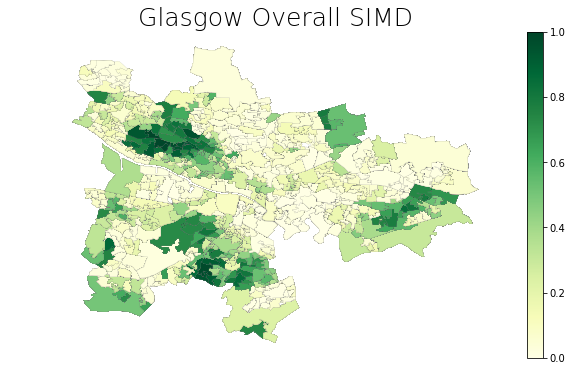

In [46]:
variable = 'overall'

fig, ax = plt.subplots(1, figsize=(10, 6))

merged_map.plot(column=variable, cmap='YlGn', ax=ax,
            linewidth=0.1, edgecolor='0.5'
#                 , scheme='equal_interval'
#             ,k=15
               )

ax.axis('off')
ax.set_title('Glasgow Overall SIMD', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlGn')
sm._A = []
cbar = fig.colorbar(sm, norm=plt.Normalize(vmin=0, vmax=1))
fig.savefig('geo_map.pdf', bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.scatter(df.overall, df.price, 1, c = "green", marker='s')
plt.grid(linestyle=':', linewidth=0.5)
plt.title("Log Transformed Sale Price")
plt.xlabel("SIMD Overall score (0 to 1)")
plt.ylabel("Log Transformed Sale Price")
fig.savefig('logged_.pdf', bbox_inches="tight")

In [ ]:
corr = df.corr()

In [ ]:
fig = plt.figure(figsize=(10,6))
heatmap_p = sns.heatmap(corr)
plt.title("Heatmap")
fig.savefig('heatmap_new_small.pdf', bbox_inches="tight")

In [ ]:
print("Features correlated to sale price:")
corr.sort_values(["price"], ascending = False, inplace = True)
print(corr.price)

In [ ]:
print("Features correlated to SIMD overall score:")
corr.sort_values(["overall"], ascending = False, inplace = True)
print(corr.overall)

In [ ]:
# Categorical features: Datazone, Build/Resale,  Buyer_Origin
# Also cat. feat. but removed: Street, Postcode, Date, Quarter, LHF

cat_features = df.select_dtypes(include = ['object']).columns
num_features = df.select_dtypes(exclude = ['object']).columns
num_features = num_features.drop('price')

print("Numerical features:", len(num_features))
print("Categorical features:", len(cat_features))

numerical_df = df[num_features]
categorical_df = df[cat_features]

print("Num. features NaNs:", numerical_df.isnull().values.sum())
print("Cat. features NaNs:", categorical_df.isnull().values.sum())
# These come from Buyer Origin

In [ ]:
# numerical_df = numerical_df.drop(columns=['geographic_access'])
numerical_df.head()

In [ ]:
# categorical_df = categorical_df.drop(columns=['build'])
categorical_df.head()

In [ ]:
categorical_df = pd.get_dummies(categorical_df)
print("Cat. features NaNs:", categorical_df.isnull().values.sum())
categorical_df.shape

In [ ]:
skewness = numerical_df.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(skewness.shape[0], "skewed numerical features to log transform:", skewness.index.values)
idx = skewness.index
numerical_df[idx] = np.log1p(numerical_df[idx])

In [ ]:
joined_df = pd.concat([numerical_df, categorical_df], axis = 1)
print(joined_df.shape)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(joined_df, target, test_size=0.3, random_state=0)
print("x_train : " + str(x_train.shape))
print("x_test : " + str(x_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

In [ ]:
joined_df.head()

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
joined_df.loc[:, num_features] = scaler.fit_transform(joined_df.loc[:, num_features])

In [ ]:
joined_df.head()

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(joined_df, target)

In [ ]:
y_train_pred = lr_model.predict(joined_df)
y_test_pred = lr_model.predict(x_test)

print("R2 Score Test:", lr_model.score(x_test, y_test).mean())
print("R2 Score Train:", lr_model.score(x_train, y_train).mean())
print("MSE Test:", mean_squared_error(y_test, y_test_pred).mean())
print("RMSE Test:", np.sqrt(mean_squared_error(y_test, y_test_pred).mean()))
print("MAE:", mean_absolute_error(y_test, y_test_pred).mean())

In [ ]:
complete_df = pd.concat([x_test, y_test], axis=1)
complete_df['predicted_price'] = y_test_pred
complete_df = complete_df[['price','predicted_price','overall','employment','income','health','education',
         'geographic_access','housing','crime']]
complete_df.to_csv(path_or_buf='complete_df.csv', index=False)
complete_df.head()

In [ ]:
# Plot pred vs price
fig = plt.figure(figsize=(10,6))
plt.scatter(complete_df.predicted_price, complete_df.price, 2, c = "green", marker = "s")
plt.title("Linear Regression - Predictions against actual prices")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.plot([10.7, 12.8], [10.6, 13.0], c = "red")
fig.savefig('linear_regression_pred_vs_price.pdf', bbox_inches="tight")

In [ ]:
feat_coff = pd.DataFrame(list(zip(joined_df.columns, lr_model.coef_)), columns = ['Features', 'Coefficients'])
feat_coff = feat_coff.sort_values(by='Coefficients', ascending=True)
feat_coff = feat_coff[feat_coff.Features.isin(num_features)]
feat_coff = feat_coff.set_index('Features')
feat_coff.to_csv(path_or_buf='coeff.csv', index=False)
feat_coff

In [ ]:
coeff_plot = feat_coff.plot(kind='barh', figsize=(10,6), color='green')
fig = coeff_plot.get_figure()
plt.grid(linestyle=':', linewidth=0.5)
plt.title("Coefficients in Linear Regression Model")
fig.savefig('linear_regression_coe2.pdf', bbox_inches="tight")

In [ ]:
# Plot residuals
fig = plt.figure(figsize=(10,6))
plt.scatter(y_train_pred, y_train_pred - y_train, 2, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, 2, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear Regression - Residuals")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc = "upper right")
plt.hlines(y = 0, xmin = 10.2, xmax = 13.3, color = "red")
fig.savefig('linear_regression_residuals2.pdf', bbox_inches="tight")

In [ ]:
# Plot predictions
fig = plt.figure(figsize=(10,6))
plt.scatter(y_train_pred, y_train, 2, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, 2,c = "orange", marker = "s", label = "Validation data")
plt.title("Linear Regression - Predictions")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.2, 13.2], [10.2, 13.2], c = "red")
fig.savefig('linear_regression_predictions2.pdf', bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
x = ['LM1 (Mean-filled NaNs)',
     'LM2 (Median-filled NaNs)',
     'LM3 (Dropped NaNs)']

y = [0.31693539877564475, 0.31693504233574776, 0.31671910295055133]
z = [0.10044804699707698, 0.10044782106036224, 0.10031099017380192]
k = [0.23322246555725637, 0.233224482923483, 0.22904849570068492]
j = [0.6311928582448882, 0.6311936877988364, 0.6528614330692613]

_X = np.arange(len(x))
plt.yticks(np.arange(0, 1, 0.05))
plt.title("Linear Regression Models Metrics", pad=50)
plt.bar(_X - 0.1, y, 0.1, color='r')
plt.bar(_X, z, 0.1, color='g')
plt.bar(_X + 0.1, k, 0.1, color='b')
plt.bar(_X + 0.2, j, 0.1, color='c')
plt.xticks(_X, x) # set labels manually
plt.grid(linestyle=':', linewidth=0.5, axis='y')
ax.legend(('Root Mean Squared Error (RMSE) (lower is better)',
           'Mean Squared Error (MSE) (lower is better)', 'Mean Absolute Error (MAE) (lower is better)', 'R2 Score (higher is better)'), bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
fig.savefig('lm_compared.pdf', bbox_inches="tight")

In [ ]:
# # Move target column as first column here
# # target = df.values[:, 0]
# # attributes = df.values[:, 1:]
# attributes = joined

# # scaled = scale(attributes)
# scaler = StandardScaler()
# scaler.fit(joined)
# scaled_attributes = scaler.transform(attributes)

In [ ]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(joined_df)

lr_model.fit(X_pca,target)

In [ ]:
var_ratio = pca.explained_variance_ratio_.cumsum()
print(var_ratio)
fig = plt.figure(figsize=(10,6))
plt.title('PCA number of Components against Variance Ratio')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 13, step=1))
plt.ylabel('Variance Ratio')
plt.plot(var_ratio, '--bo')
fig.savefig('pca_components_variance.pdf', bbox_inches="tight")

In [ ]:
n_samples, n_features = joined_df.shape
n_digits = len(np.unique(target))
model = cluster.AgglomerativeClustering(n_clusters=n_digits, linkage="ward", affinity="euclidean")
model.fit(joined_df)

print("length:", n_digits)
print("n samples:", n_samples, "n features:", n_features)

print(metrics.silhouette_score(joined_df, model.labels_))
print(metrics.completeness_score(target, model.labels_))
print(metrics.homogeneity_score(target, model.labels_))

In [ ]:
Z = linkage(joined_df, 'ward')

In [ ]:
np.savetxt("from_price_to_dz.csv", Z, delimiter=",")

In [ ]:
fig = plt.figure(figsize=(20,70))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Distance')
plt.ylabel('Sample Index')
dendrogram(
    Z,
    p=20,
    truncate_mode='lastp',
    orientation='right',
    leaf_rotation=90.,
    leaf_font_size=8.
    )
fig.savefig('dendro_ward_fulllarg.pdf', bbox_inches="tight")

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
x = ['Ward - Euclidean',
     'Average - Euclidean',
     'Average - Manhattan',
     'Complete - Euclidean',
     'Complete - Manhattan']

y = [0.4585054410838514, 0.411178230729844, 0.38054918724238823,
     0.41757725658002337, 0.3939523655501585]
z = [0.8871998368269876, 0.8714664029864378, 0.8705347573408821,
     0.8804779252681949, 0.8787845930927598]
k = [0.8590934815745167, 0.8570671637777433, 0.8569801407406784,
     0.8581845355703639, 0.8580289478960755]

_X = np.arange(len(x))
plt.yticks(np.arange(0, 1, 0.1))
plt.title("Hierarchical Clustering Scores", pad=35)
plt.bar(_X - 0.1, y, 0.1, color='r')
plt.bar(_X, z, 0.1, color='g')
plt.bar(_X + 0.1, k, 0.1, color='b')
plt.xticks(_X, x) # set labels manually
plt.grid(linestyle=':', linewidth=0.5, axis='y')
ax.legend(('Silhouette Score', 'Homogeneity Score',
           'Completeness Score'), bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
fig.savefig('hierarchical_compared2.pdf', bbox_inches="tight")

In [ ]:
c, coph_dists = cophenet(Z, pdist(scaled_attributes))
c

In [ ]:
print(len(scaled_attributes))
print(10299 - len(scaled_attributes))
print(list(map('{:.0f}'.format,Z[1080])))
print(list(map('{:.0f}'.format,Z[408])))

In [ ]:
df.iloc[[60211 - len(target)]]

# print(df.values[6740])
# print(vg_sales.as_matrix()[3568])
# print(df.values[1876])
# print(vg_sales.as_matrix()[3568])